<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [6]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [7]:
!nvidia-smi

Sun Sep 13 21:05:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
%pip install hyperopt

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data,metric_cnr, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [10]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [11]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [12]:
X = X.drop(['ID','WF','Set'],axis=1)

In [13]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,...,CLCT_Distance_Max,CLCT_Distance_Min,U_100m_Distance_Max,U_100m_Distance_Min,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,6.936299,0.583268,1.687717,0.895782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.690,86.504507,5.7895,3.8202,1.054669,1.317597
2018-05-01 02:00:00,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,7.170127,0.578533,1.723264,1.036951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.770,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 03:00:00,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,6.000870,0.151837,1.707938,0.981212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 04:00:00,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,5.470862,0.312855,1.454695,0.786528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 05:00:00,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,4.896512,0.143904,1.280704,0.660129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-159,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483


## Fill NaN's

To avoid Exploding Gradients, here the NaN's are filled.

In [14]:
X = X.fillna(method="ffill", axis=1) # ZOH
X = X.fillna(0)

In [15]:
y = y.fillna(method="ffill", axis=1) # ZOH
y = y.fillna(0)

## Scaling Data

For a better performance of the Network, here the data is scaled between [-1,1] using MinMaxScaler. For the Direction Data, presented in degrees, Sin and Cos are calculated, which naturally have values in this same scale.

In [16]:
directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))

directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
directions = directions.reset_index().drop('Time',axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [17]:
X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
X_columns = X.columns

In [18]:
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=X_columns)

In [19]:
X = pd.concat([X,directions],axis=1)

In [20]:
y = y.drop('ID',axis=1)
y = scaler.fit_transform(y)
y = pd.DataFrame(y)

In [21]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Speed 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,V_10mLast_Month_Variance,cos_day,...,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max,Sin_Wind Direction 100m,Cos_Wind Direction 100m,Sin_Wind Direction 10m,Cos_Wind Direction 10m
0,0.228968,0.130650,-0.080167,0.046187,-0.652228,0.730090,-0.235387,-0.710735,-0.998463,-0.998463,-0.998463,-0.982084,-0.982084,-0.982084,-0.104511,-0.104511,-0.104511,-0.051678,-0.051678,-0.051678,-0.097700,-0.097700,-0.097700,0.004222,0.004222,0.004222,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0.010180,0.999948,0.015634,0.999878
1,0.243537,0.136909,-0.099786,0.062691,-0.648044,0.979522,-0.209145,-0.704468,-0.997542,-0.997542,-0.997542,-0.979261,-0.979261,-0.979261,-0.094891,-0.094891,-0.094891,-0.042877,-0.042877,-0.042877,-0.082122,-0.082122,-0.082122,0.018267,0.018267,0.018267,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.994934,0.848259,-0.962208,-0.985599,-1.0,-0.965395,0.010097,0.999949,0.018097,0.999836
2,0.238667,-0.050938,-0.091757,0.056334,-0.590239,0.283872,-0.340364,-0.707170,-0.997906,-0.997906,-0.997906,-0.980376,-0.980376,-0.980376,-0.098689,-0.098689,-0.098689,-0.046352,-0.046352,-0.046352,-0.088273,-0.088273,-0.088273,0.012721,0.012721,0.012721,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.924962,0.848259,-0.962208,-0.985599,-1.0,-0.965395,0.002650,0.999996,0.017125,0.999853
3,0.189158,-0.002548,-0.083169,0.017554,-0.654321,0.149650,-0.399844,-0.751810,-0.999176,-0.999176,-0.999176,-0.984269,-0.984269,-0.984269,-0.111956,-0.111956,-0.111956,-0.058490,-0.058490,-0.058490,-0.109757,-0.109757,-0.109757,-0.006647,-0.006647,-0.006647,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0

In [22]:
y

,0
0,-0.778768
1,-0.631774
2,-0.671863
3,-0.778768
4,-0.814402
...,...
6234,-0.768374
6235,-0.808463
6236,-0.867854
6237,-0.839644


In [23]:
y.shape

(6239, 1)

## Subsets Creation

Here, the Data is converted to a group of subsets where each subset has n_steps of past data.

In [24]:
n_steps = 60

In [25]:
# split a multivariate sequence into samples
def split_sequences(X, y = None, n_steps = 1):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x = X[i:end_ix, :]
		sample_X.append(seq_x)
		if y is not None:
			seq_y = y[end_ix-1,-1]
			sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [26]:
def shift_save(df,n_steps):
  empty = pd.DataFrame(np.zeros((n_steps-1,df.shape[1])),columns=df.columns)
  df = pd.concat([empty,df])
  return df

In [27]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [28]:
n_features = sample_X.shape[2]

## Model

Here, a function to create the Model usin Keras is defined.

In [29]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=128,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.1)(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=87,return_sequences=True,stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.1)(hidden_2)

  hidden_3 = tf.keras.layers.LSTM(units=57,stateful=True)(hidden_2)
  hidden_3 = tf.keras.layers.Dropout(0.1)(hidden_3)


  # Output
  #outputs = tf.keras.layers.PReLU()(hidden_2)
  #outputs = tf.keras.layers.Dropout(rate=0.2)(hidden_2)
  outputs = tf.keras.layers.Dense(units=1)(hidden_3)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [30]:
def LSTM_Model_2(param, input_shape, batch_size=1,):

  n1 = param['Neurons_1']
  d1 = param['Dropout_1']
  n2 = param['Neurons_2']
  d2 = param['Dropout_2']
  n3 = param['Neurons_3']
  d3 = param['Dropout_3']

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.InputLayer(input_shape = input_shape,batch_size = batch_size))

  if n1 != 0:
    model.add(tf.keras.layers.LSTM(units=n1,return_sequences=True,stateful=True))
    model.add(tf.keras.layers.Dropout(d1))

  if n2 != 0:
    model.add(tf.keras.layers.LSTM(units=n2,return_sequences=True,stateful=True))
    model.add(tf.keras.layers.Dropout(d2))

  if n2 != 0:
    model.add(tf.keras.layers.LSTM(units=n3,stateful=True))
    model.add(tf.keras.layers.Dropout(d3))

  model.add(tf.keras.layers.Dense(units=1))

  return model

In [31]:
input_shape = (n_steps,n_features)

In [32]:
model = LSTM_Model(input_shape)

In [33]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 60, 95)]             0         
_________________________________________________________________
lstm (LSTM)                  (1, 60, 128)              114688    
_________________________________________________________________
dropout (Dropout)            (1, 60, 128)              0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 60, 87)               75168     
_________________________________________________________________
dropout_1 (Dropout)          (1, 60, 87)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 57)                   33060     
_________________________________________________________________
dropout_2 (Dropout)          (1, 57)                  

## Validation

In [34]:
patience = 3
epochs = 10
monitor = "root_mean_squared_error"
batch_size = 1

In [35]:
def objective(param,epochs=epochs,patience=patience,monitor=monitor,input_shape=input_shape,batch_size=batch_size):

  X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

  X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
  X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
  X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

  model = LSTM_Model_2(param=param,input_shape=input_shape,batch_size=batch_size)

  callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

  preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

  preds = scaler.inverse_transform(preds)
  y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

  _,cape = metric_cnr(preds,y_holdout)

  return {'loss' : cape, 'params' : param, 'status' : STATUS_OK}

In [49]:
space = {
    'Neurons_1' : hp.choice('Neurons_1', np.arange(1,128,dtype=int)),
    'Dropout_1' : hp.uniform('Dropout_1', 0, 1),
    'Neurons_2' : hp.choice('Neurons_2', np.arange(1,128,dtype=int)),
    'Dropout_2' : hp.uniform('Dropout_2', 0, 1),
    'Neurons_3' : hp.choice('Neurons_3', np.arange(1,128,dtype=int)),
    'Dropout_3' : hp.uniform('Dropout_3', 0, 1)
}

In [50]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()

In [51]:
MAX_EVALS = 100

In [52]:
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

A saída de streaming foi truncada nas últimas 5000 linhas.
 - ETA: 37s - loss: 0.0171 - root_mean_squared_error: 0.1309

1263/4218 [=======>......................]
 - ETA: 37s - loss: 0.0171 - root_mean_squared_error: 0.1309

1268/4218 [========>.....................]
 - ETA: 37s - loss: 0.0171 - root_mean_squared_error: 0.1307

1272/4218 [========>.....................]
 - ETA: 37s - loss: 0.0172 - root_mean_squared_error: 0.1310

1276/4218 [========>.....................]
 - ETA: 37s - loss: 0.0173 - root_mean_squared_error: 0.1315


AttributeError: ignored

In [ ]:
best

### Hold Out Score

Here, the same model is trained on all the data used on the Validation and tested on a Holdout Set never seen before.

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)

In [ ]:
#X_train, y_train = X_train.iloc[-n_rows:],y_train.iloc[-n_rows:]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [ ]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [ ]:
model = LSTM_Model(input_shape)

In [ ]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4619/4619 [==============================] - 48s 10ms/step - loss: 0.0590 - root_mean_squared_error: 0.2430 - val_loss: 0.1575 - val_root_mean_squared_error: 0.3969
Epoch 2/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763 - val_loss: 0.0641 - val_root_mean_squared_error: 0.2531
Epoch 3/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.0738 - val_root_mean_squared_error: 0.2716
Epoch 4/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.1059 - val_root_mean_squared_error: 0.3253
Epoch 5/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023
Epoch 6/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 -

In [ ]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

Here, Predicitions and True Labels of the Holdout Set are scaled back to measure the CAPE Error, and be compared on a Chart.

In [ ]:
preds = scaler.inverse_transform(preds)
y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

In [ ]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [ ]:
metric_cnr(preds,y_holdout)

('CAPE', 31.5137094342074)

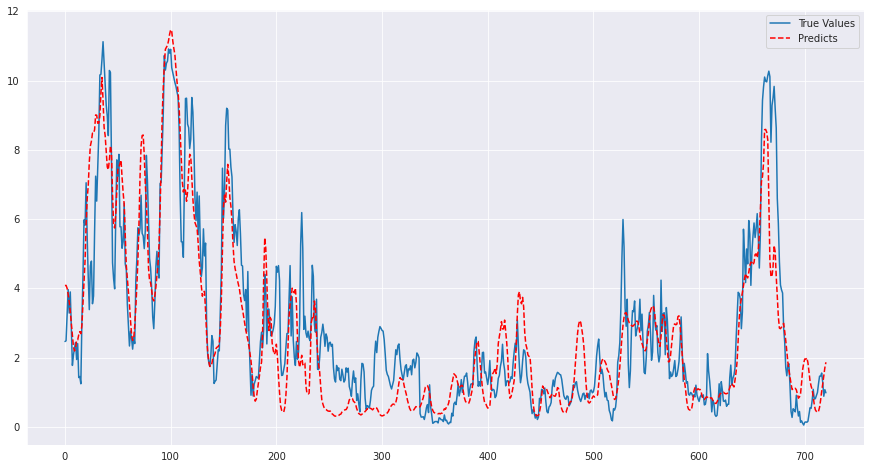

In [ ]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Submission Generation

First, a function with all the preprocessing made to prepare data for network is defined.

In [ ]:
def preprocessing_X(X):

  scaler = MinMaxScaler(feature_range=(-1,1))

  X_saved_columns = X[['ID','WF','Set','Month_Number']]
  X_saved_columns = X_saved_columns.reset_index().drop('Time',axis=1)
  X = X.drop(['ID','WF','Set','Month_Number'],axis=1)

  # Fill NaN's
  X = X.fillna(method="ffill", axis=1) # ZOH
  X = X.fillna(0)

  # Scaling Data
  directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
  directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
  directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
  directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
  directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))
  directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  directions = directions.reset_index().drop('Time',axis=1)

  X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  X_columns = X.columns

  X = scaler.fit_transform(X)
  X = pd.DataFrame(X,columns=X_columns)
  X = pd.concat([X,directions],axis=1)
  X = pd.concat([X,X_saved_columns],axis=1)

  return X

In [ ]:
def preprocessing_y(y):

  scaler = MinMaxScaler(feature_range=(-1,1))

  y = y.fillna(method="ffill", axis=1) # ZOH
  y = y.fillna(0)
  y = y.drop('ID',axis=1)
  y = scaler.fit_transform(y)
  y = pd.DataFrame(y)

  return y,scaler

Here's a Function with all the Process of Submit Gen for One Wind Farm. This Model is the Standard:

In [ ]:
def WF_submit_gen(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test = full_X_test.reset_index().drop('index',axis=1)
  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Months Loop
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue
    
    # Separate Month Data on Numpy Matrix
    ids = X_test.index
    X_test = full_X_test_split[[ids]]

    # Append Data Already Predicted
    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

Some changes are tried here:

In [ ]:
def WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)

  # Months Loop
  WF_preds = pd.DataFrame()
  predicted_X_test = pd.DataFrame()
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue

    # Subset Generation on Test Data
    X_test = X_test.reset_index().drop('index',axis=1)
    X_test_split = X_test.drop(['ID','WF','Set'],axis=1)
    #X_test_split = shift_save(full_X_test_split,n_steps)
    X_test_split, _ = split_sequences(X_test_split.values,None,n_steps)
    
    # Append Data Already Predicted
    X_train = pd.concat([full_X_train,predicted_X_test],axis=0)
    y_train = pd.concat([full_y_train,WF_preds],axis=0)

    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test_split,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = pd.concat([predicted_X_test,X_test],axis=0)
    WF_preds = np.append(WF_preds,pred)
    WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
    WF_preds = pd.DataFrame(WF_preds)

  return WF_preds

In [ ]:
def WF_submit_gen_3(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Split Train Data on Train and Validation Set
  X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, test_size=0.3, shuffle=False)

  # Model Creation and Training
  model = LSTM_Model(input_shape,batch_size=batch_size)
  callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

  # Prediction Generation
  pred = model.predict(full_X_test_split,batch_size = batch_size,callbacks=callbacks_list)
  pred = pred.reshape(pred.shape[0])

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(pred))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [ ]:
final_preds = pd.DataFrame()
for WF in full_data['WF'].unique():
  WF_preds = WF_submit_gen_3(full_data,full_label,WF,input_shape,batch_size)
  final_preds = final_preds.append(WF_preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706 - val_loss: 0.4896 - val_root_mean_squared_error: 0.6997
Epoch 2/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760 - val_loss: 0.4950 - val_root_mean_squared_error: 0.7036
Epoch 3/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862 - val_loss: 0.4967 - val_root_mean_squared_error: 0.7048
Epoch 4/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.2293 - root_mean_squared_error: 0.4788 - val_loss: 0.5008 - val_root_mean_squared_error: 0.7077


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.0669 - root_mean_squared_error: 0.2587 - val_loss: 0.2439 - val_root_mean_squared_error: 0.4939
Epoch 2/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0644 - root_mean_squared_error: 0.2537 - val_loss: 0.2399 - val_root_mean_squared_error: 0.4898
Epoch 3/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0649 - root_mean_squared_error: 0.2548 - val_loss: 0.2408 - val_root_mean_squared_error: 0.4907
Epoch 4/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0644 - root_mean_squared_error: 0.2539 - val_loss: 0.2389 - val_root_mean_squared_error: 0.4888
Epoch 5/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.0651 - root_mean_squared_error: 0.2552 - val_loss: 0.2422 - val_root_mean_squared_error: 0.4921


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0854 - root_mean_squared_error: 0.2923 - val_loss: 0.2284 - val_root_mean_squared_error: 0.4779
Epoch 2/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0849 - root_mean_squared_error: 0.2915 - val_loss: 0.2180 - val_root_mean_squared_error: 0.4669
Epoch 3/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926 - val_loss: 0.2149 - val_root_mean_squared_error: 0.4636
Epoch 4/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0830 - root_mean_squared_error: 0.2882 - val_loss: 0.2155 - val_root_mean_squared_error: 0.4642
Epoch 5/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807 - val_loss: 0.2259 - val_root_mean_squared_error: 0.4753
Epoch 6/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0772 - root_mean_squared_error: 0.2779 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 48s 11ms/step - loss: 0.0674 - root_mean_squared_error: 0.2597 - val_loss: 0.2646 - val_root_mean_squared_error: 0.5144
Epoch 2/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0675 - root_mean_squared_error: 0.2598 - val_loss: 0.2660 - val_root_mean_squared_error: 0.5157
Epoch 3/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.2626 - val_root_mean_squared_error: 0.5125
Epoch 4/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0663 - root_mean_squared_error: 0.2575 - val_loss: 0.2670 - val_root_mean_squared_error: 0.5167
Epoch 5/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0687 - root_mean_squared_error: 0.2622 - val_loss: 0.2676 - val_root_mean_squared_error: 0.5173
Epoch 6/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.0678 - root_mean_squared_error: 0.2603 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4284/4284 [==============================] - 47s 11ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.2607 - val_root_mean_squared_error: 0.5106
Epoch 2/10
4284/4284 [==============================] - 46s 11ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143 - val_loss: 0.2543 - val_root_mean_squared_error: 0.5043
Epoch 3/10
4284/4284 [==============================] - 47s 11ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143 - val_loss: 0.2533 - val_root_mean_squared_error: 0.5033
Epoch 4/10
4284/4284 [==============================] - 47s 11ms/step - loss: 0.0468 - root_mean_squared_error: 0.2164 - val_loss: 0.2514 - val_root_mean_squared_error: 0.5014


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4326/4326 [==============================] - 49s 11ms/step - loss: 0.1532 - root_mean_squared_error: 0.3914 - val_loss: 0.3641 - val_root_mean_squared_error: 0.6034
Epoch 2/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.1729 - root_mean_squared_error: 0.4158 - val_loss: 0.3458 - val_root_mean_squared_error: 0.5880
Epoch 3/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.1704 - root_mean_squared_error: 0.4128 - val_loss: 0.3439 - val_root_mean_squared_error: 0.5864
Epoch 4/10
4326/4326 [==============================] - 47s 11ms/step - loss: 0.1709 - root_mean_squared_error: 0.4134 - val_loss: 0.3421 - val_root_mean_squared_error: 0.5849


In [ ]:
final_preds = final_preds.reset_index().drop('index',axis=1)
final_preds['ID'] = pd.read_csv(r'random_submission_example.csv')['ID']
final_preds = final_preds.set_index('ID')

In [ ]:
final_preds

,Production
ID,
37376,3.023962
37377,3.018954
37378,3.013116
37379,3.011632
37380,3.011119
...,...
73900,1.387582
73901,1.387581
73902,1.387580


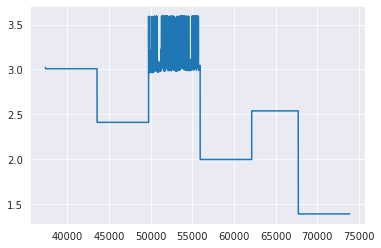

In [ ]:
plt.plot(final_preds.index,final_preds['Production'])

In [ ]:
final_preds.to_csv('Submission_LSTM.csv')

In [ ]:
from google.colab import files
files.download('Submission_LSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>